<a href="https://colab.research.google.com/github/FrancescoZanni/MLPNS_FZanni/blob/main/NeuralNetworks/CNN_Molecules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

Mounted at /content/drive/


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras


In [ ]:
plt.rcParams["figure.figsize"] = [10,8];
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gist_gray" 

In [ ]:
cd drive/MyDrive/MLPNS_2023/

/content/drive/MyDrive/MLPNS_2023


In [ ]:
ls

higgsClasse/  kaggletitanic/  model.png  spm/  spm-20210427T111354Z-001.zip


In [ ]:
!unzip spm-20210427T111354Z-001.zip

Archive:  spm-20210427T111354Z-001.zip
replace spm/spm_struct_pos.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace spm/spm_struct_neg.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace spm/test_good_all.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace spm/train_good_all.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace spm/test_bad_all.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace spm/train_bad_all.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
data = np.load("spm/train_good_all.npy")
#carico solo il training e poi lo splitto

In [ ]:
data.shape

(1302, 64, 64)

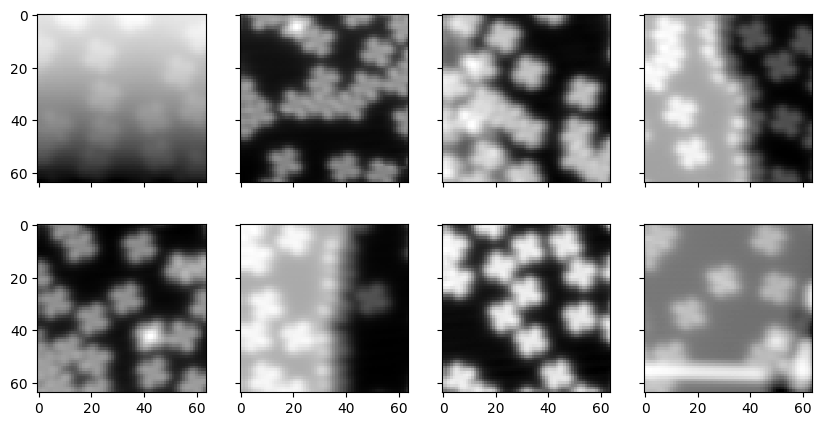

In [ ]:
fig, ax = plt.subplots(2,4,sharex=True, sharey=True,figsize=[10,5]) 
#sharey e share y vuol dire che mette i tick labels solo a sinistra e solo in fondo 

for ii in range(8): #alternativamente faccio il ciclo su die indici
  ax[ii//4,ii%4].imshow(data[ii])

Vogliamo creare un object detector, ovvero cerchiamo una rete che 
identifichi la posizione di certi oggetti nelle immagini.

Per farlo con i convolutional neural networks ho bisogno di dare degli esempi di dove sono degli oggetti che voglio identificare e dove non sono.

Quello che impara il NN sono le forme interessanti, ovvero le featire maps.



(array([ 254226.,  957465., 1143646., 1050540.,  825288.,  338534.,
         391059.,  151471.,  179803.,   40960.]),
 array([-1.07775726e-07, -9.55749615e-08, -8.33741970e-08, -7.11734324e-08,
        -5.89726678e-08, -4.67719032e-08, -3.45711387e-08, -2.23703741e-08,
        -1.01696095e-08,  2.03115507e-09,  1.42319196e-08]),
 <BarContainer object of 10 artists>)

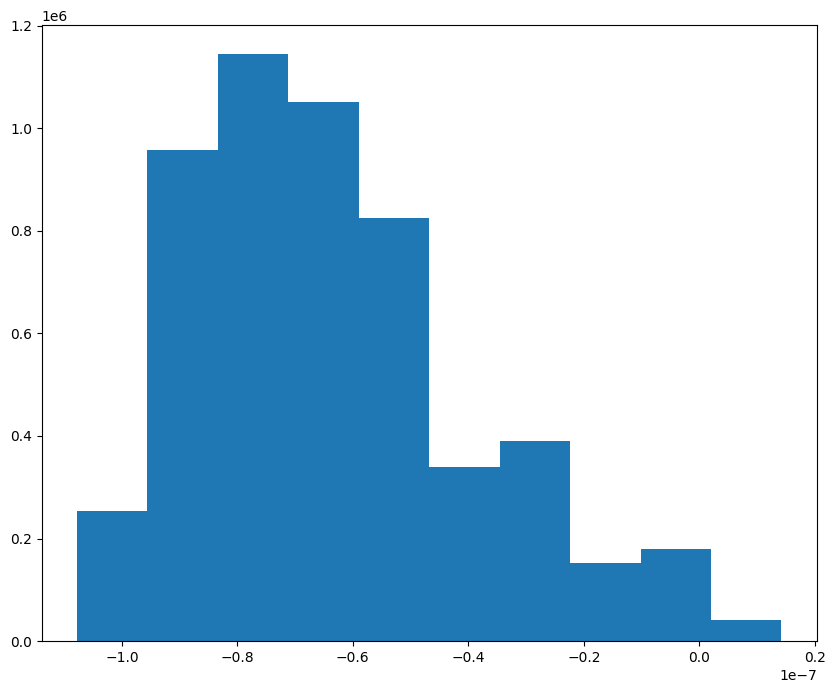

In [ ]:
plt.hist(data.flatten())
#estraggo tutti i valori dei pixel e li metto in riga per farne un istogramma.

Non mi piace che i valori siano in 10 alla -7.

Tipicamente quello che si fa come preprocessing e MINMAX preprocessing, scalo fra 0 e 1 tutto allo stesso modo.

Prendo i dati e ne creo una versione normalizzata: 
norm = (data- minData)/range(data).

Questo non va bene se ho dati di background gaussiani e quello che mi interessa sta su una delle code!


In [ ]:
norm = (data - data.min(axis=(1, 2), keepdims=True)) / (data.max(axis=(1, 2), keepdims=True) - 
                                                        data.min(axis=(1, 2), keepdims=True))

In [ ]:
print(norm.shape)
print([norm.min(),norm.max()])

(1302, 64, 64)
[0.0, 1.0]


In [ ]:
#leggo le labels che passerò al NN, sono separate tra annotazioni positive e annotazioni negative!

pos=np.load("spm/spm_struct_pos.npy")
neg=np.load("spm/spm_struct_neg.npy")

In [ ]:
[pos.shape,neg.shape]
#500 label negative e 500 positive, ciascuna label contiene 3 numeri:
#numero dell'immagine e posizioni sugli assi

#

[(500, 3), (500, 3)]

In [ ]:
pos.max(axis=0)
#Il numero dell'immagine è il terzo valore!!


array([  62,   62, 1300])

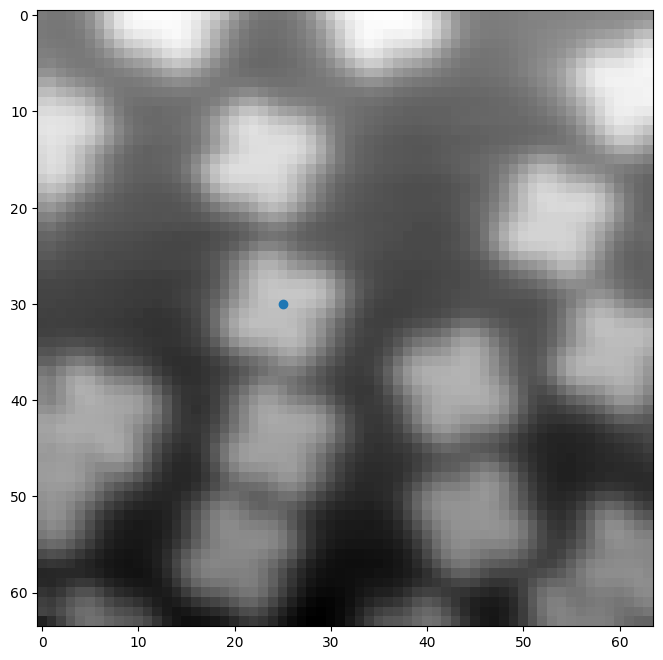

In [ ]:
#per capire gli indici faccio una visualizzazione
plt.imshow(norm[pos[0][2]]) #mostro un immagine della quale so le posizioni
plt.plot(pos[0][1],pos[0][0],'o') #metto il punto dove pos mi dice che c'è una molecola


Voglio costruire un train set dove ho immegini con solo la molecola o solo la "non-molecola".

Voglio creade postage stamps, francobolli, centrati nella molecola, così la isolo!

A occhio stabilisco che i francobolli saranno di lato 20

In [ ]:
wid = 10 #metà del lato del francobollo 
stmp_pos = []
for ii in range(pos.shape[0]): #numero delle annotazioni positive
  trow,tcol,tind = pos[ii]
  if (trow>wid) & (trow< 64- wid) & (tcol>wid) & (tcol< 64- wid):
    #controllo di non sovrappormi al bordo
    stmp_pos.append(norm[tind, trow-wid:trow+wid,tcol-wid:tcol+wid]) 
    #ci metto il numero dell'immagine e i pixel 10 prima e 10 dopo nelle righe e nelle colonne

stmp_pos = np.array(stmp_pos)
#lo metto in un array invece che lista perchè più efficiente lavorarci

  

In [ ]:
#ovviamente non tutte erano lontane dai bordi
stmp_pos.shape

(389, 20, 20)

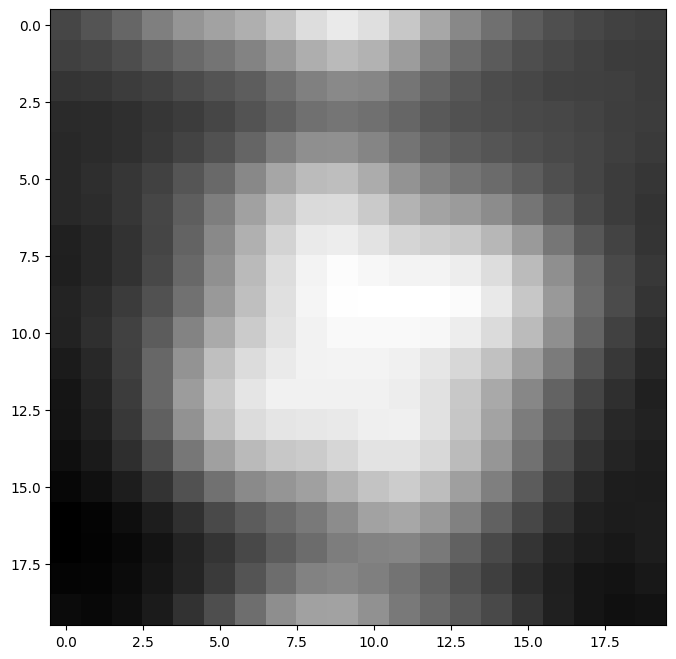

In [ ]:
#mostro un esempio di molecola
plt.imshow(stmp_pos[0])

In [ ]:
#stessa cosa per le annotazioni negative
stmp_neg = []
for ii in range(neg.shape[0]): 
  trow,tcol,tind = neg[ii]
  if (trow>wid) & (trow< 64- wid) & (tcol>wid) & (tcol< 64- wid):
    stmp_neg.append(norm[tind, trow-wid:trow+wid,tcol-wid:tcol+wid]) 
   
stmp_neg = np.array(stmp_neg)

  

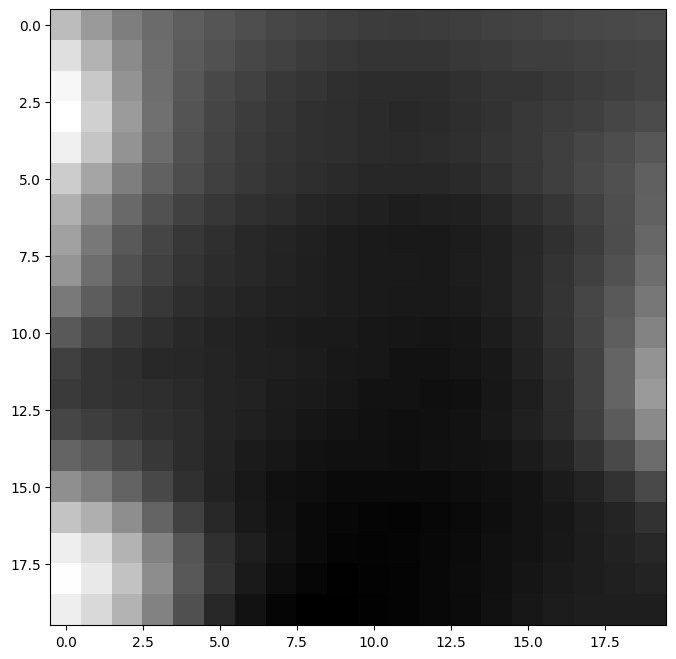

In [ ]:
plt.imshow(stmp_neg[0])
#il neg non è solo nero ma anche tutto quello che può capitare che non è una molecola!
#per esempio cose con la forma sbagliata, strisce strane ecc


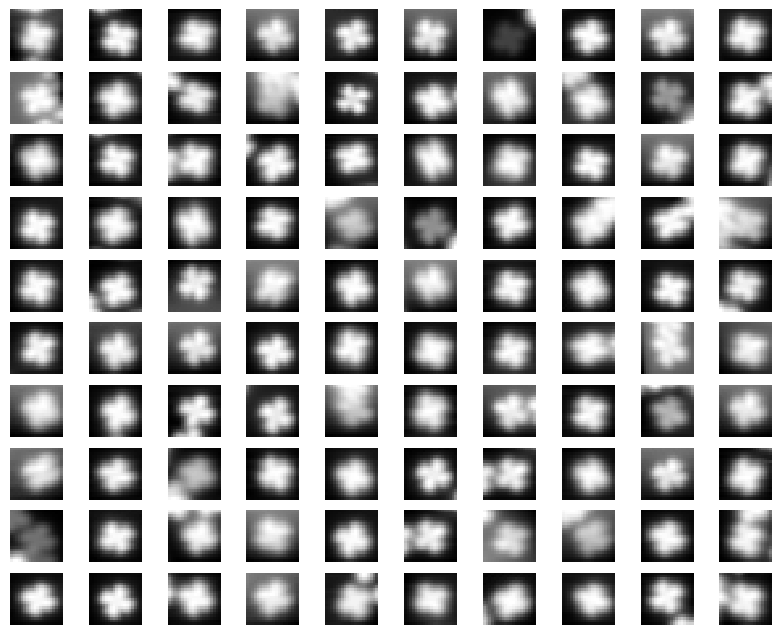

In [ ]:

# plot  positive examples
fig, ax = plt.subplots(10, 10)
for ii in range(100):
    ax[ii // 10, ii % 10].imshow(stmp_pos[ii])
    ax[ii // 10, ii % 10].axis("off")

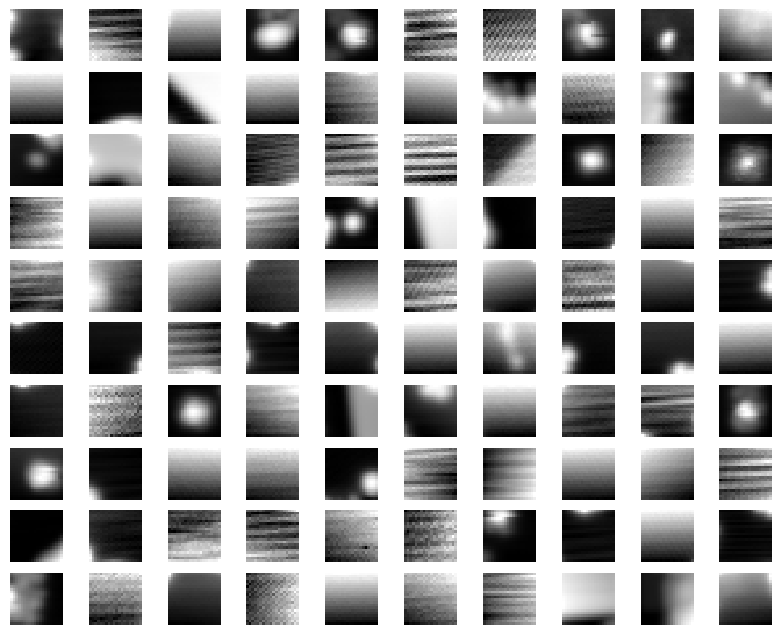

In [ ]:

# plot  positive examples
fig, ax = plt.subplots(10, 10)
for ii in range(100):
    ax[ii // 10, ii % 10].imshow(stmp_neg[ii])
    ax[ii // 10, ii % 10].axis("off")

In [ ]:
#creo le features
feat = np.concatenate((stmp_neg, stmp_pos), axis =0)

#creo il target: 0 per le feature negative e 1 per le positive
targ = np.concatenate((np.zeros(stmp_neg.shape[0]),
                      np.ones(stmp_pos.shape[0])))


In [ ]:
targ

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
print(feat.shape)
print(targ.shape)

(874, 20, 20)
(874,)


In [ ]:
#
feat_tr, feat_te, targ_tr, targ_te = train_test_split(feat, targ,
                                                      random_state=420, shuffle=True)
#non ho specificato le percentuali di train e test, va di default a 75-25
#non ho ragione di pensare che non vada bene 

feat_tr.shape

(655, 20, 20)

In [ ]:
#tensorflow vuole immagini a colori ma le mie sono in bianco e nero! 
#aggiungo un asse
feat_tr = np.expand_dims(feat_tr, axis=3)
feat_tr.shape


(655, 20, 20, 1)

Creo la rete neurale (ESERCIZIO)


In [ ]:
#FATTO DA ME 

layer1 = keras.layers.Conv2D(16, kernel_size=(5, 5), padding="same", 
                             activation="relu", 
                             input_shape=(2 * wid, 2 * wid, 1), #needed in the first layer only
                             kernel_regularizer=keras.regularizers.l2(0.001))

layer2 = keras.layers.MaxPool2D(pool_size=(2,2),padding="same")

layer3 = keras.layers.Conv2D(16, kernel_size=(5, 5), padding="same", 
                             activation="relu", 
                             kernel_regularizer=keras.regularizers.l2(0.001))

layer4 = keras.layers.MaxPool2D(pool_size=(2,2),padding="same")

layer5 = keras.layers.Flatten()

layer6 = keras.layers.Dense(64, activation = "relu")

layer7 = keras.layers.Dense(2, activation = "softmax") #softmax perchè ho un classifier


layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7]
model = keras.Sequential(layers)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 20, 16)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        6416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dense (Dense)               (None, 64)                2

In [ ]:
  #FATTO DALLA PROF
  layer1 = keras.layers.Conv2D(16, kernel_size=(5, 5), padding="same", 
                              activation="relu", 
                              input_shape=(2 * wid, 2 * wid, 1), #needed in the first layer only
                              kernel_regularizer=keras.regularizers.l2(0.001))

  layer2 = keras.layers.MaxPool2D(2)
  layer3 = keras.layers.Conv2D(32, kernel_size=(5, 5), padding="same", 
                              activation="relu", 
                              kernel_regularizer=keras.regularizers.l2(0.001))
  layer4 = keras.layers.MaxPool2D(2)
  layer5 = keras.layers.Flatten()
  layer6 = keras.layers.Dense(64, activation="relu",
                              kernel_regularizer=keras.regularizers.l2(0.001))
  layer7 = keras.layers.Dense(2, activation="softmax")

  layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7]
  model = keras.Sequential(layers)
  model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 20, 20, 16)        416       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 32)        12832     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 dense_2 (Dense)             (None, 64)               

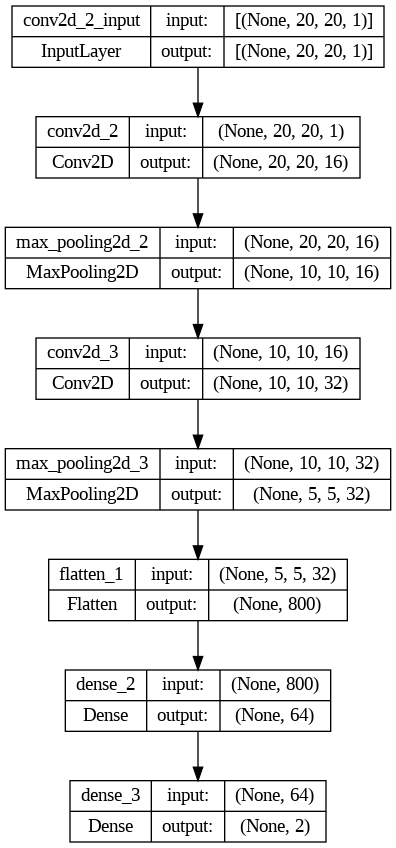

In [ ]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics = "accuracy")
#non facciamo più regression, quindi mae, ora classificazione

In [ ]:
results = model.fit(feat_tr, targ_tr, epochs = 50,batch_size = 50, validation_split=0.1)
#lo salvo per poter fare il plot della loss func
#batch è quello che si chiama minibatching: facio il training su sottoinsiemi per evitare l'overfitting
#prendo il 10% dei dati e ne faccio la validation

Epoch 1/50
12/12 [==============================] - 14s 98ms/step - loss: 0.7543 - accuracy: 0.8302 - val_loss: 0.6366 - val_accuracy: 0.8333
Epoch 2/50
12/12 [==============================] - 0s 10ms/step - loss: 0.4919 - accuracy: 0.8998 - val_loss: 0.4029 - val_accuracy: 0.8485
Epoch 3/50
12/12 [==============================] - 0s 11ms/step - loss: 0.3609 - accuracy: 0.9219 - val_loss: 0.2449 - val_accuracy: 0.9545
Epoch 4/50
12/12 [==============================] - 0s 10ms/step - loss: 0.2800 - accuracy: 0.9338 - val_loss: 0.1849 - val_accuracy: 0.9697
Epoch 5/50
12/12 [==============================] - 0s 10ms/step - loss: 0.2499 - accuracy: 0.9474 - val_loss: 0.2192 - val_accuracy: 0.9242
Epoch 6/50
12/12 [==============================] - 0s 10ms/step - loss: 0.2270 - accuracy: 0.9508 - val_loss: 0.1389 - val_accuracy: 0.9848
Epoch 7/50
12/12 [==============================] - 0s 11ms/step - loss: 0.2289 - accuracy: 0.9508 - val_loss: 0.1271 - val_accuracy: 1.0000
Epoch 8/50
1

Text(0.5, 1.0, 'Loss Function')

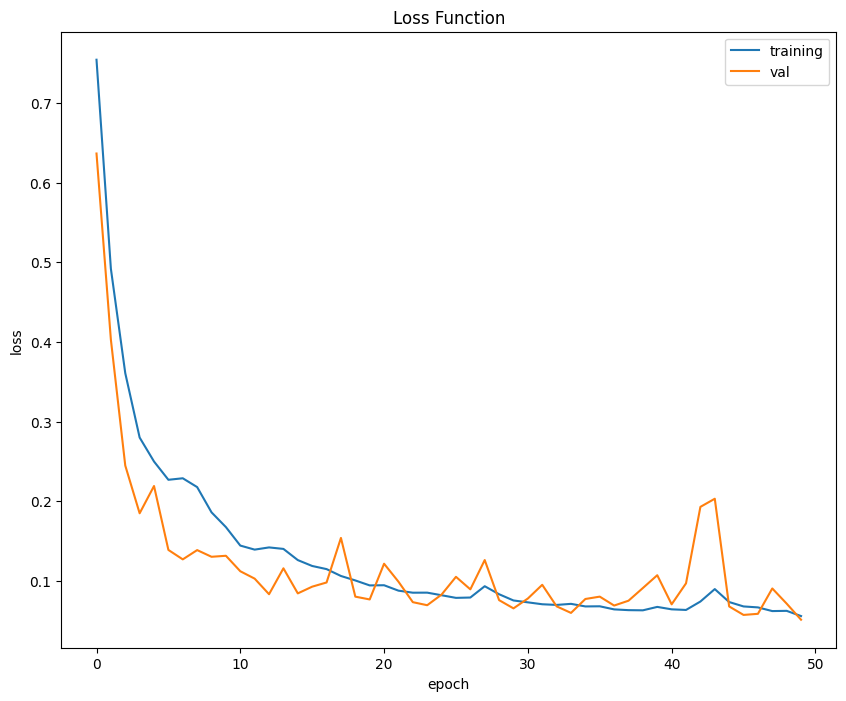

In [ ]:
plt.plot(results.history["loss"], label="training")
plt.plot(results.history["val_loss"],label = "val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Loss Function")

Il fatto che la training sia più smooth implica che ci sia del rumore e che il problema è difficile, un modo per migliorare potrebbe essere diminuire il learning rate. 

In [ ]:
results.history["val_accuracy"]

[0.8333333134651184,
 0.8484848737716675,
 0.9545454382896423,
 0.9696969985961914,
 0.9242424368858337,
 0.9848484992980957,
 1.0,
 1.0,
 0.9696969985961914,
 0.9848484992980957,
 0.9848484992980957,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9696969985961914,
 1.0,
 1.0,
 0.9696969985961914,
 0.9848484992980957,
 1.0,
 1.0,
 1.0,
 0.9848484992980957,
 0.9848484992980957,
 0.9696969985961914,
 1.0,
 1.0,
 1.0,
 0.9848484992980957,
 1.0,
 1.0,
 1.0,
 0.9848484992980957,
 1.0,
 1.0,
 0.9848484992980957,
 0.9696969985961914,
 1.0,
 0.9848484992980957,
 0.939393937587738,
 0.9242424368858337,
 1.0,
 1.0,
 1.0,
 0.9848484992980957,
 0.9848484992980957,
 1.0]

Text(0.5, 1.0, 'Accuracy')

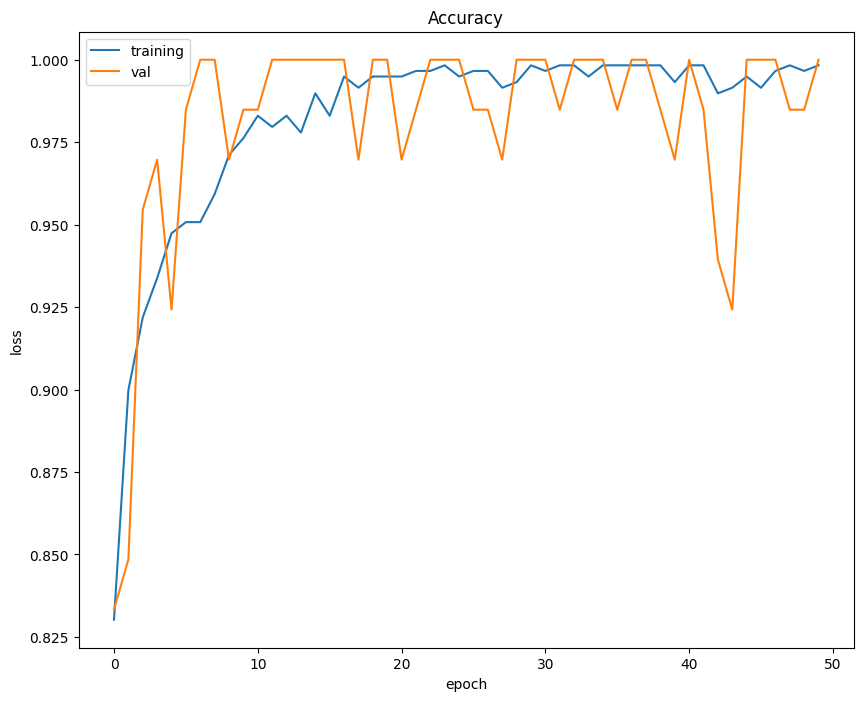

In [ ]:
plt.plot(results.history["accuracy"], label="training")
plt.plot(results.history["val_accuracy"],label = "val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Accuracy")

In [ ]:
feat_te = np.expand_dims(feat_te, axis=3)

In [ ]:
loss_tr, acc_tr = model.evaluate(feat_tr, targ_tr)
loss_te, acc_te = model.evaluate(feat_te, targ_te) #??????
loss_tr, acc_tr, loss_te, acc_te

7/7 [==============================] - 0s 12ms/step - loss: 0.1274 - accuracy: 0.9726


(0.05450589209794998,
 0.9984732866287231,
 0.12739984691143036,
 0.9726027250289917)

Domani continuiamo per portare questa cosa sulle immagini 64x64 e non più sui francobolli!


###Lezione successiva


In [ ]:
pos[0]

array([30, 25, 51])

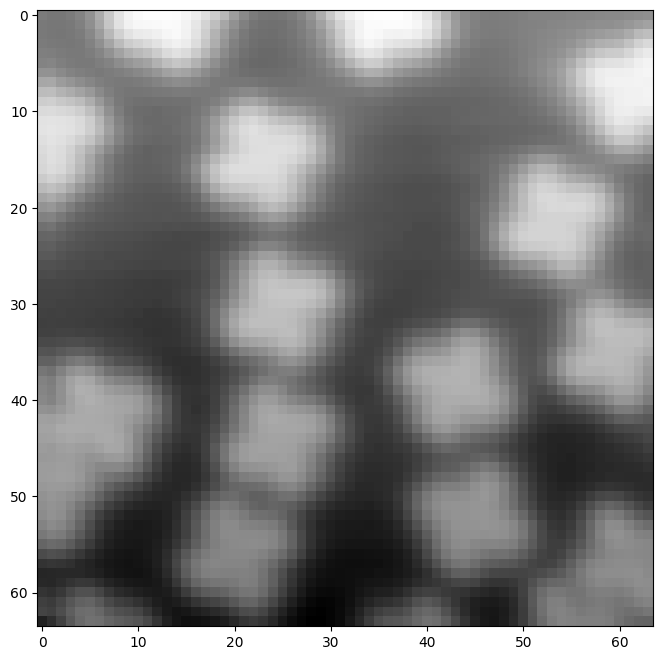

In [ ]:
plt.imshow(norm[51])

In [ ]:
img = norm[51].copy() #metto copia se no crea un puntatore non duplica

In [ ]:
nrow, ncol = img.shape
stamps = np.zeros(((nrow-wid*2) * (ncol- wid*2), 2*wid, 2*wid)) #so già la dimensione del "contenitore", quindi lo creo direttamente come array e non come lista

#voglio che gli stamps siano interi quindi tengo conto della larghezza
#le dimensioni sono: numero di stamps, larghezza e altezza e le metto in una lista intera, non le metto separate

In [ ]:
kk = 0

for ii in range(wid,nrow - wid): #loop sulle righe
  for jj in range(wid,ncol - wid):
    stamps[kk] = img[ii-wid:ii+wid, jj-wid:jj+wid]
    kk += 1

feat_stmp = np.expand_dims(stamps, axis=3)
#come prima keras vuole una terza dimensione

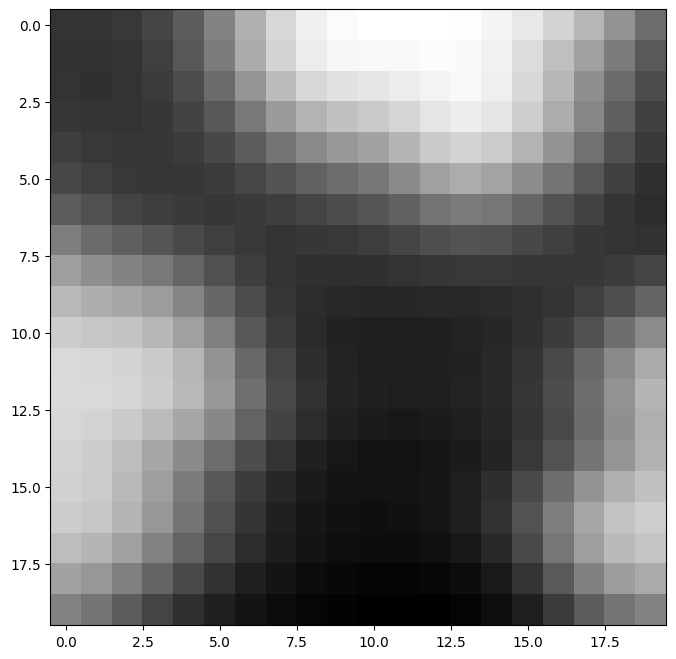

In [ ]:
#mostro il primo
plt.imshow(feat_stmp[1])

In [ ]:
pred = model.predict(feat_stmp)

61/61 [==============================] - 0s 4ms/step


In [ ]:
pred.shape
#1936 stamps
#2 sono i neuroni di output

#il primo valore è la probabilità che la classificazione sia "non molecola"
#il secondo è la prob che la classificazione sia "molecola"

(1936, 2)

In [ ]:
#prediction image
#sui bordi avrò tutti 0 perchè non li sto considerando ma ok lo so in anticipo 
pimg = np.zeros(img.shape)
pimg[wid:nrow-wid,wid:ncol-wid] = pred[:,1] .reshape(nrow-2*wid,ncol-2*wid)
 #metto il secondo valore di pred ma tanto sono complementari quindi non cambia niente
 #quando lo visualizza le zone con valore alto saranno dove la prob che ci sia una molecola è alta 


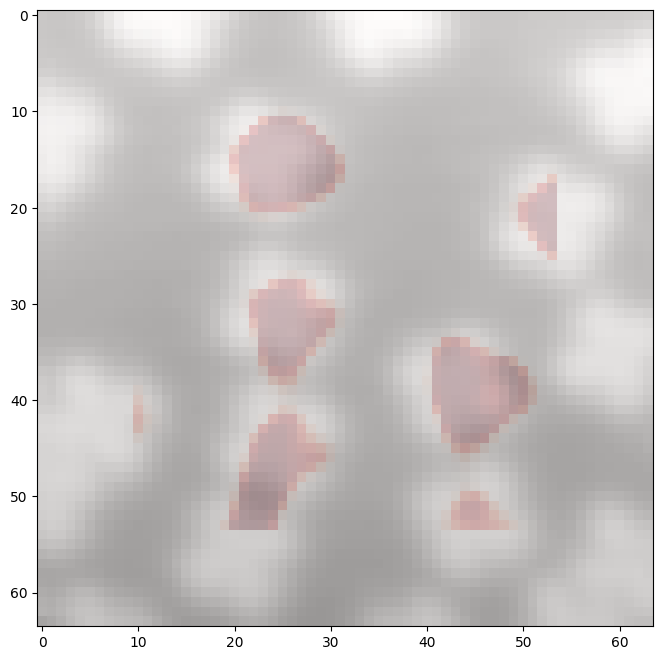

In [ ]:
plt.imshow(img, alpha=0.5)

plt.imshow(pimg, cmap = "Reds", alpha = 0.2)

Ho une regione dove posso trovare il centro, questa regione ha il gradiente.

mi aspetto che sia una distribuzione di probabilità che ha il picco dove si trova il centro reale della molecola

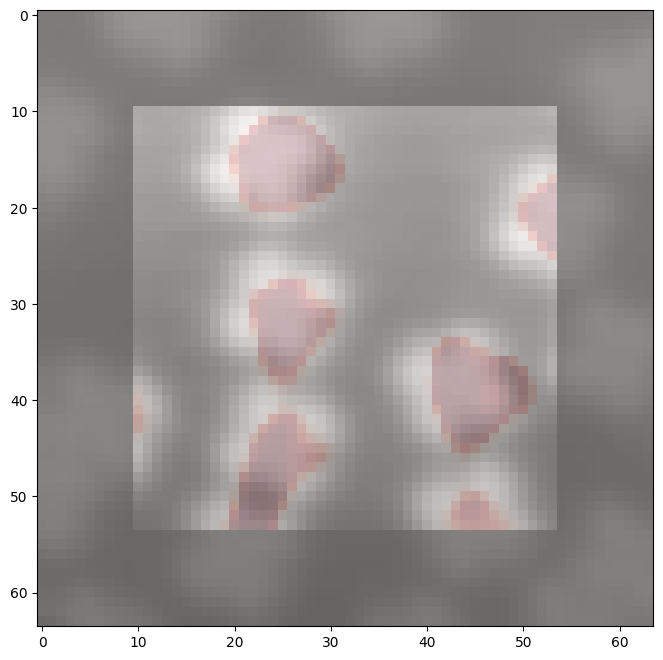

In [ ]:
plt.imshow(img, alpha=0.5)
actualimg = img.copy()
actualimg[:wid,:] = 0
actualimg[-wid:,:] = 0
actualimg[:,:wid] = 0
actualimg[:,-wid:] = 0
plt.imshow(actualimg, alpha=0.5)
plt.imshow(pimg, cmap="Reds", alpha=0.2)

#copiato da slack, unica cosa è che mi fa vedere il bordo 


#passa a altro notebook (che sarà su github)

Nel codice sono mostrati anche i kernels, ovvero le feature maps, ovvero il risultato del training dei neuroni, possono essere oppure no informativi sul tipo di forme che vengono cercate/trovate.  

Mostro poi i neuron nel dense layer, che sono il risultato diaver passato le immagini attraverso tutta la parte che fa convoluzione: mi aspetto di vedere delle differenze fra le cose relative a zone positive e negative, perchè è quello che viene poi dato all'ultimo layer per fare la classificazione .

Blu annotazioni positive, rosso negative.  
Se li guardo insieme "vedo" delle differenze, sulle quali il NN capitalizza per fare la classificazione in modo molto efficace.

Dopo nel codice mostra altre cose ma niente di nuovo/interessante, è sostanzialmente quello che butta fuori DeepDream



##Commento sulla regolarizzazione
Noi abbiamo messo L2.


Quello che fanno è aggiungere un pezzo alla loss function impedendo che i neuroni diventino troppo grandi: diminuiscono la possibilità di exploding gradient

##Contro l'overfitting
Fare dropout: a caso alcuni dei neuroni vengono eliminati: impedisco che il contenuto e l'informazioni vengano dominati da quel neurone. 


Fare minibatching, già detto ieri, il training set viene diviso in sottoset...



#Yolo & RCNN
Due modelli usati per la object localization.


Tutto sulle slide




#Physics Informed NNs

Vedi registrazioni ultimi 25 minuti 